In [1]:
%matplotlib inline

import sys
import os
import logging
import ast

import numpy as np
import pandas as pd
from scipy import stats
import scipy
pd.options.display.float_format = '{:,.2f}'.format

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

sns.set(style='ticks')
sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader

## Read data

In [2]:
config = Reader.read_config('../../endure.toml')

In [3]:
df_og = pd.read_csv('/Users/ndhuynh/sandbox/data/exp01.csv')
df_og['robust_cost'] = np.around(df_og['robust_cost'], 4)
df_og['nominal_cost'] = np.around(df_og['nominal_cost'], 4)
df_og['robust_throughput'] = 1 / df_og['robust_cost']
df_og['nominal_throughput'] = 1 / df_og['nominal_cost']
df_og['delta_throughput'] = (df_og['robust_throughput'] - df_og['nominal_throughput']) / df_og['nominal_throughput']
df_og['speedup'] = df_og['robust_throughput'] / df_og['nominal_throughput'] 
df_og['robust_rho'] = np.around(df_og['robust_rho'], 2)
df_og['delta_rho'] = df_og['robust_rho'] - df_og['rho_hat']

In [4]:
df = df_og
df.describe()

,workload_idx,z0,z1,q,w,robust_rho,robust_h,robust_T,robust_Q,nominal_h,...,q_hat,w_hat,sample_idx,nominal_cost,robust_cost,robust_throughput,nominal_throughput,delta_throughput,speedup,delta_rho
count,"2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00",...,"2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00","2,880,000.00"
mean,8.50,0.27,0.23,0.21,0.28,1.88,3.02,18.02,4.11,4.72,...,0.25,0.25,"4,999.50",5.74,5.70,0.28,0.30,0.00,1.00,0.37
std,5.19,0.27,0.26,0.26,0.29,1.15,3.11,17.07,5.10,3.14,...,0.19,0.19,"2,886.75",5.08,5.05,0.18,0.22,0.16,0.16,1.54
min,0.00,0.01,0.01,0.01,0.01,0.00,0.00,5.92,1.00,0.00,...,0.00,0.00,0.00,0.23,0.23,0.02,0.02,-0.89,0.11,-4.41
25%,4.00,0.01,0.01,0.01,0.01,0.94,0.00,6.67,1.17,3.10,...,0.09,0.09,"2,499.75",2.63,2.78,0.15,0.15,-0.01,0.99,-0.68
50%,8.50,0.28,0.15,0.06,0.29,1.88,2.75,9.73,1.32,4.52,...,0.20,0.20,"4,999.50",3.84,3.71,0.27,0.26,0.00,1.00,0.38
75%,13.00,0.49,0.33,0.33,0.49,2.81,5.42,17.83,7.57,7.93,...,0.37,0.37,"7,499.25",6.87,6.71,0.36,0.38,0.00,1.00,1.52
max,17.00,0.97,0.97,0.97,0.97,3.75,9.47,50.00,18.81,8.78,...,0.96,0.97,"9,999.00",44.54,44.54,4.37,4.37,1.37,2.37,3.75


## Visualization Directory

In [5]:
VIZ_DIR = '/Users/ndhuynh/sandbox/viz'

In [6]:
def set_style(fsz=14):
    sns.set_context("paper")    
    mpl.rcParams["font.family"] = 'serif'
    mpl.rcParams["font.size"] = f'{fsz}'
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    # plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    plt.tight_layout()
    
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

## Plot histogram of KL divergence

In [7]:
def plot_KL_divergence_histogram(df, workload_idx, color='blue', hatch='', bins=50):
    ymin, ymax = (0.0, 0.22)
    df = df[df['workload_idx'] == workload_idx]
    if workload_idx == 0:
        bins = 20
    weights = np.ones_like(df.rho_hat) / len(df.rho_hat)
    n, bins, patches = plt.hist(df.rho_hat, bins=bins, weights=weights, color=color, rasterized=True, hatch=hatch)
    plt.xlabel('$I_{KL}(\hat{w}, w)$')
    plt.ylabel('Probability Density')
    plt.ylim([ymin, ymax])
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

In [8]:
def plot_overlapping_histogram(df):
    color1, color2 = ('tab:blue', 'orange')
    fig, ax0 = plot_KL_divergence_histogram(df, 0, color=color1, hatch='//')
    fig, ax1 = plot_KL_divergence_histogram(df, 1, color=color2, hatch='')
    legend_elements = [Patch(facecolor=color1, hatch='//', label=r'$w_0: (25\%, 25\%, 25\%, 25\%)$'),
                       Patch(facecolor=color2, hatch='', label=r'$w_1: (97\%, 1\%, 1\%, 1\%)$')]   
    l = plt.legend(handles=legend_elements, loc='right', shadow=False, 
                   bbox_to_anchor=(1., 0.75), frameon=False)
    return fig, [ax0, ax1]

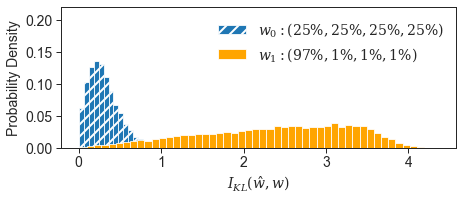

In [9]:
set_style(fsz=14)
fig, axes = plot_overlapping_histogram(df)
set_size(fig, width=3.33 * 2, height=2 * 1.5)
save_fig(fig, "KL_divergence_histogram.pdf")

## Plot changing scatter plot

In [10]:
def plot_three_scatterplots(df, workload_idx=11, rhos=[0, 0.25, 1, 2]):
    fig, axes = plt.subplots(nrows=1, ncols=len(rhos), sharey=True)
    plt.ylim(-1, 3.5)
    axes[0].set_ylabel(r'$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$')
    df = df[df['workload_idx'] == workload_idx]
    dfs = []
    for rho in rhos:
        dfs.append(df[df.robust_rho == rho])
    
    for i in range(len(rhos)):
        robust_policy = np.around(dfs[i].iloc[0].robust_Q, 1)
        robust_T = np.around(dfs[i].iloc[0].robust_T, 1)
        robust_h = np.around(dfs[i].iloc[0].robust_h)
        
        df_pos = dfs[i][dfs[i].delta_throughput >= 0]
        df_neg = dfs[i][dfs[i].delta_throughput < 0]
        deltas_pos = df_pos.delta_throughput
        rho_hats_pos = df_pos.rho_hat
        deltas_neg = df_neg.delta_throughput
        rho_hats_neg = df_neg.rho_hat
        axes[i].scatter(rho_hats_pos, deltas_pos, s=5, color='tab:green', rasterized=True)
        axes[i].scatter(rho_hats_neg, deltas_neg, s=5, color='tab:gray', rasterized=True)
        axes[i].axhline(y=0, color='k', linestyle='--')
        axes[i].set_xlabel(r'$I_{KL}(\hat{w}, w_{' + str(workload_idx) + '})$')
        axes[i].set_title(r'$\rho:${}'.format(rhos[i]))
        rect = mpatches.Rectangle((-1, 0), 6, 4, linewidth=1, color='tab:green', fill=True, alpha=0.20)
        axes[i].add_patch(rect)
        axes[i].text(0, 1.7, f'Robust Tuning\n$Q$:  {robust_policy}\n$T$:  {robust_T}\n$h$:  {robust_h}')

    z0, z1, q, w = df[['z0', 'z1', 'q', 'w']].iloc[0]
    wl_str = f'({z0:.0%}, {z1:.0%}, {q:.0%}, {w:.0%})'
    axes[0].text(0, 1.1, '$w_{' + str(workload_idx) + '}$ = ' + wl_str)
    return fig, axes 

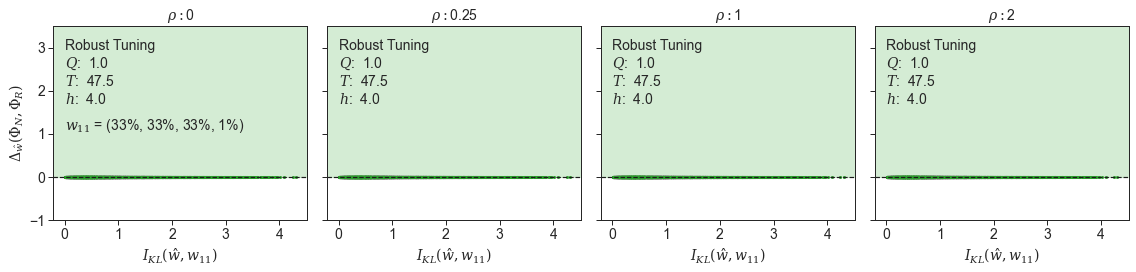

In [11]:
set_style(fsz=14)
fig, axes = plot_three_scatterplots(df, workload_idx=11)
set_size(fig, width=2*8, height=2*(2))
save_fig(fig, "scatterplot_evolution_rho.pdf")

In [12]:
# for wl_idx in range(18):
#     fig, axes = plot_three_scatterplots(df, workload_idx=wl_idx)
#     set_size(fig, width=2*7, height=2*(2.33))
#     save_fig(fig, f'scatterplot_evolution_rho_wl{wl_idx}_1e12.pdf')

## Rho vs Rho hat

In [13]:
def plot_rho_vs_rho_hat(df, workload_idx):
    df = df[df.workload_idx == workload_idx]
    x1 = np.arange(df['robust_rho'].min(), df['robust_rho'].max(), 0.75)
    y1 = np.arange(df['rho_hat'].min(), df['rho_hat'].max(), 0.75)
    x2, y2 = np.meshgrid(x1, y1)
    
    z2 = scipy.interpolate.griddata((df['robust_rho'], df['rho_hat']), df['delta_throughput'], (x2, y2),
                                   method='linear')
    h = plt.contourf(x1, y1, z2, 10, cmap='RdGy')
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 20
    cbar.set_label('Delta Throughput', rotation=270)
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$I_{KL}(\hat{w}, w)$')
    plt.title(r'Workload Idx:{}'.format(workload_idx))
    ax = plt.gca()
    fig = plt.gcf()
    return fig, ax

In [14]:
def plot_rho_vs_rho_hat_grid(df, workloads=[5,7,11,12]):
    workloads = np.array(workloads).reshape((2,2))
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    for i in range(2):
        for j in range(2):
            plt.sca(axes[i, j])
            df0 = df[df.workload_idx == workloads[i][j]]
            z0, z1, q, w = df0[['z0', 'z1', 'q', 'w']].iloc[0]
            
            x1 = np.arange(0, 3.5, 0.5)
            y1 = np.arange(0, 3.5, 0.5)
            x2, y2 = np.meshgrid(x1, y1)
            z2 = scipy.interpolate.griddata((df0['robust_rho'], df0['rho_hat']), df0['delta_throughput'],
                                           (x2, y2), method='nearest')
            h = plt.contourf(x1, y1, z2, 10, cmap='RdYlGn')
            for c in h.collections:
                c.set_rasterized(True)
            cbar = plt.colorbar()
            cbar.ax.get_yaxis().labelpad = 10
            if j == 1:
                cbar.set_label('Norm. Delta Throuhgput: $\Delta_(\Phi_N, \Phi_R)$', rotation=270)
            if i == 1:
                plt.xlabel(r'$\rho$')
            if j == 0:
                plt.ylabel(r'$I_{KL}(\hat{w}, w)$')
            plt.title(r'$w$: ({:.0%}%, {:.0%}%, {:.0%}%, {:.0%}%)'.format(z0, z1, q, w))
    return fig, axes        

In [15]:
def plot_rho_vs_rho_hat_row(df, workloads=[7,11]):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    for idx in range(2):
        plt.sca(axes[idx])
        df0 = df[df.workload_idx == workloads[idx]]
        z0, z1, q, w = df0[['z0', 'z1', 'q', 'w']].iloc[0]

        x1 = np.arange(0, 3.5, 0.5)
        y1 = np.arange(0, 3.5, 0.5)
        x2, y2 = np.meshgrid(x1, y1)
        z2 = scipy.interpolate.griddata((df0['robust_rho'], df0['rho_hat']), df0['delta_throughput'],
                                       (x2, y2), method='nearest')
        h = plt.contourf(x1, y1, z2, 10, cmap='viridis')
        for c in h.collections:
            c.set_rasterized(True)
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 10
        plt.title(f'$w_{{{workloads[idx]}}}$: ' + f'({z0:.0%}, {z1:.0%}, {q:.0%}, {w:.0%})', pad=20)
    fig.supxlabel(r'$\rho$', y=0.05)
    fig.supylabel(r'$I_{KL}(\hat{w}, w)$', x=0.03)
    cbar.set_label('$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$', rotation=270, labelpad=45)
    return fig, axes        

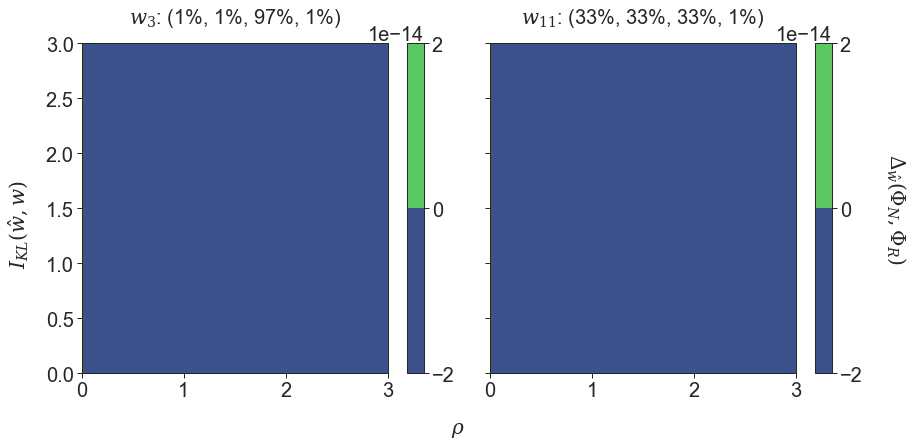

In [63]:
set_style(fsz=20)
fig, axes = plot_rho_vs_rho_hat_row(df, [3, 11])
set_size(fig, width=4*3.33, height=4*1.66)
save_fig(fig, "rho_vs_rho_hat.pdf")

In [17]:
df.sort_values(by='delta_throughput')

,workload_idx,z0,z1,q,w,robust_rho,robust_h,robust_T,robust_Q,nominal_h,...,q_hat,w_hat,sample_idx,nominal_cost,robust_cost,robust_throughput,nominal_throughput,delta_throughput,speedup,delta_rho
313317,1,0.97,0.01,0.01,0.01,3.75,0.00,6.63,1.31,8.78,...,0.01,0.02,3317,0.24,2.17,0.46,4.22,-0.89,0.11,3.69
2713317,16,0.70,0.20,0.01,0.01,3.75,0.00,6.65,1.31,8.51,...,0.01,0.02,3317,0.24,2.17,0.46,4.21,-0.89,0.11,3.57
959481,5,0.49,0.49,0.01,0.01,3.75,0.00,6.63,1.31,8.21,...,0.05,0.00,9481,0.25,2.25,0.44,4.05,-0.89,0.11,3.13
303317,1,0.97,0.01,0.01,0.01,3.50,0.00,6.56,1.30,8.78,...,0.01,0.02,3317,0.24,2.16,0.46,4.22,-0.89,0.11,3.44
2703317,16,0.70,0.20,0.01,0.01,3.50,0.00,6.58,1.30,8.51,...,0.01,0.02,3317,0.24,2.16,0.46,4.21,-0.89,0.11,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554015,15,0.10,0.10,0.10,0.70,3.75,0.00,6.68,1.33,3.47,...,0.92,0.00,4015,10.56,4.45,0.22,0.09,1.37,2.37,1.80
2434015,15,0.10,0.10,0.10,0.70,0.75,0.00,6.68,1.33,3.47,...,0.92,0.00,4015,10.56,4.45,0.22,0.09,1.37,2.37,-1.20
2534015,15,0.10,0.10,0.10,0.70,3.25,0.00,6.68,1.33,3.47,...,0.92,0.00,4015,10.56,4.45,0.22,0.09,1.37,2.37,1.30
2544015,15,0.10,0.10,0.10,0.70,3.50,0.00,6.68,1.33,3.47,...,0.92,0.00,4015,10.56,4.45,0.22,0.09,1.37,2.37,1.55


## Delta Throughput evolution with rho

In [18]:
def plot_delta_throughput_with_rho(df):
    uniforms = [0]
    unimodals = [1,2,3,4]
    bimodals = [5,6,7,8,9,10]
    trimodals = [11,12,13,14]
    
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Unimodals", marker="d", markersize=10,
                     color='tab:blue', data=df[df.workload_idx.isin(unimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Bimodals", marker="X", markersize=10,
                     color='tab:green', data=df[df.workload_idx.isin(bimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Trimodals", marker="o", markersize=10,
                     color='tab:orange', data=df[df.workload_idx.isin(trimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Uniform", marker="P", markersize=10,
                     color='tab:red', data=df[df.workload_idx.isin(uniforms)])
    
        
    l = g.legend(loc='right',
                 shadow=False,
                 frameon=True,
                 fancybox=False,
                 framealpha=1,
                 bbox_to_anchor=(1,0.23), ncol=2)
    
    plt.xlabel(r'$\rho}$')
    plt.ylabel(r'$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$')
#     plt.ylim([-0.1, 1.8])
    plt.xlim([0, 3.5])
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

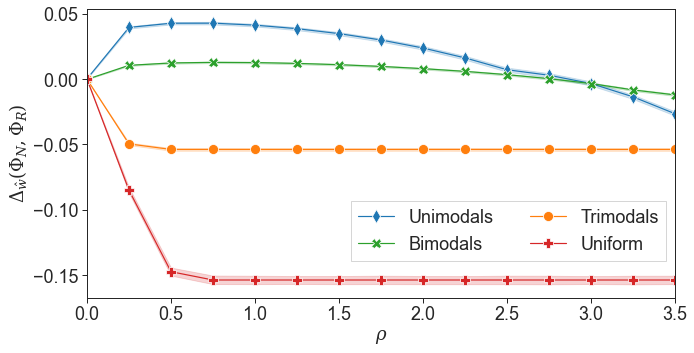

In [61]:
set_style(fsz=18)
fig, ax = plot_delta_throughput_with_rho(df)
set_size(fig, width=3*3.33, height=3*1.75)
# save_fig(fig, "delta_throughput_workload_type.pdf")

In [20]:
def plot_throughput_range_evolution(df):
    df = df.copy()
    df['nominal_max_throughput'] = df['nominal_throughput']
    df['nominal_min_throughput'] = df['nominal_throughput']
    df['robust_max_throughput'] = df['robust_throughput']
    df['robust_min_throughput'] = df['robust_throughput']
    df = df.groupby(['workload_idx', 'robust_rho']).agg({'nominal_max_throughput':'max', 
                                                             'nominal_min_throughput': 'min',
                                                             'robust_max_throughput':'max', 
                                                             'robust_min_throughput': 'min'})
    df = df.reset_index()
    df['nominal_range'] = df['nominal_max_throughput'] - df['nominal_min_throughput']
    df['robust_range'] = df['robust_max_throughput'] - df['robust_min_throughput']
    g = sns.lineplot(x='robust_rho', y='nominal_range', color='tab:gray', marker="*", markersize=12,
                     label='Nominal', data=df)
    g = sns.lineplot(x='robust_rho', y='robust_range', color='tab:green', marker="o", markersize=7.5,
                     label='Robust', data=df)
    l = g.legend(shadow=False, frameon=False, loc=(0.52, 0.35))
    
    plt.title(' ')
    plt.xlabel(r'$\rho}$')
    plt.ylabel(r'$\Theta_{\mathcal{B}}(\Phi)$')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

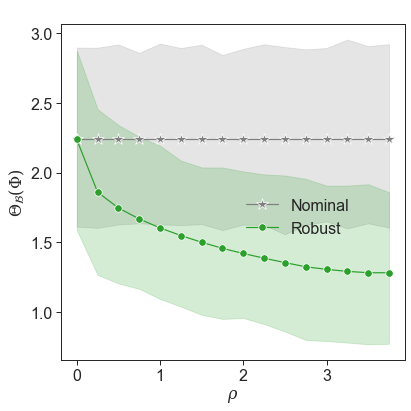

In [64]:
set_style(fsz=16)
fig, ax = plot_throughput_range_evolution(df)
set_size(fig, width=3*2, height=3*2)
# save_fig(fig, 'throughput_range_evolution.pdf')

### Histogram of throughputs

In [69]:
def plot_overlapping_hist(df, workload_idx=11, rhos=[0, 0.25, 1, 2], bins=25):
    hist_range = (0, 1.5)
    wl_txt = str(workload_idx)
    fig, axes = plt.subplots(nrows=1, ncols=len(rhos), sharey=True)
    axes[0].set_ylabel(r'Delta Throughput')
    df = df[df['workload_idx'] == workload_idx]
    dfs = []
    for rho in rhos:
        dfs.append(df[df.robust_rho == rho])
        
    for i in range(len(rhos)):
        robust_policy = np.around(dfs[i].iloc[0].robust_Q, 1)
        robust_T = np.around(dfs[i].iloc[0].robust_T, 1)
        robust_h = np.around(dfs[i].iloc[0].robust_h, 1)
        
        nominal_policy = np.around(dfs[i].iloc[0].nominal_Q, 1)
        nominal_T = np.around(dfs[i].iloc[0].nominal_T, 1)
        nominal_h = np.around(dfs[i].iloc[0].nominal_h, 1)
        
        weights = np.ones_like(dfs[i]['nominal_throughput']) / len(dfs[i]['nominal_throughput'])
        axes[i].hist(dfs[i]['nominal_throughput'], weights=weights, bins=bins, alpha=1, 
                     color='tab:gray', range=hist_range)
        axes[i].hist(dfs[i]['robust_throughput'], weights=weights, bins=bins, alpha=0.8, 
                     color='tab:green', range=hist_range)
        axes[i].set_ylim(0, 0.4)
            
        
        axes[i].set_xlabel(r'$1$ / $C(\hat{w}, \Phi)$')
        if i == 0:
            axes[i].set_ylabel(r'Probability Density')
        axes[i].set_title(r'$\rho:${}'.format(rhos[i]))
        axes[i].add_patch(mpatches.Rectangle((0.38, 0.55), 0.6, 0.35,
                                             linewidth=1,
                                             color='tab:green',
                                             fill=True,
                                             alpha=0.2,
                                             transform=axes[i].transAxes))
        axes[i].text(0.405, 0.60, f'Robust\n$\pi$:  {robust_policy}\nT:  {robust_T}\nh:  {robust_h}', transform=axes[i].transAxes)
        
        if i == 0:
            axes[i].add_patch(mpatches.Rectangle((0.38, 0.05), 0.6, 0.35,
                                                 linewidth=1,
                                                 color='tab:gray',
                                                 fill=True,
                                                 alpha=0.2,
                                                 transform=axes[i].transAxes))
            axes[i].text(0.405, 0.10, f'Nominal\n$\pi$:  {nominal_policy}\nT:  {nominal_T}\nh:  {nominal_h}', transform=axes[i].transAxes)
            
    return fig, ax

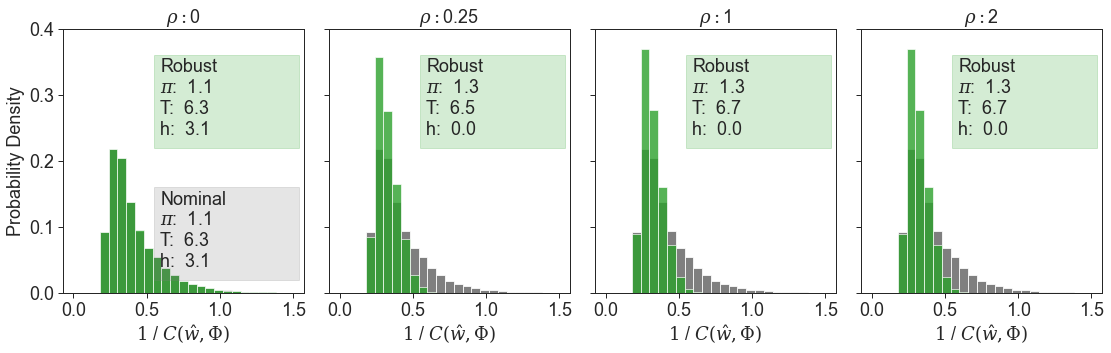

In [70]:
set_style(fsz=18)
fig, ax = plot_overlapping_hist(df, workload_idx=13)
set_size(fig, width=3*5.25, height=3*1.75)
save_fig(fig, 'overlapping_histogram.pdf')

In [24]:
# for wl_idx in range(18):
#     set_style()
#     fig, ax = plot_overlapping_hist(df, workload_idx=wl_idx)
#     set_size(fig, width=2*5.25, height=2*1.75)
#     save_fig(fig, f'overlapping_histogram_wl{wl_idx}_1e12.pdf') 

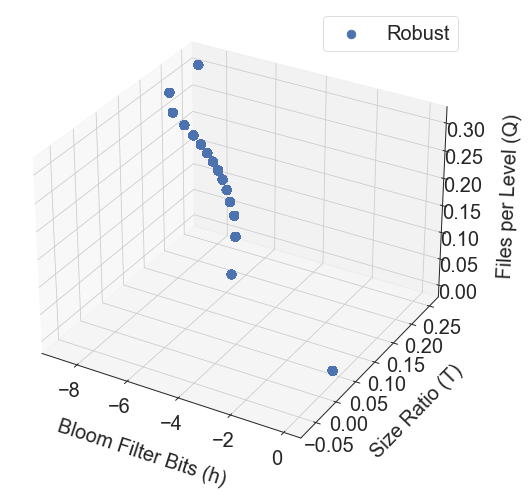

In [59]:
set_style(fsz=20)
fig = plt.figure()
data = df[df['workload_idx'] == 1]
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=data['robust_h'] - data['nominal_h'],
           ys=data['robust_T'] - data['nominal_T'],
           zs=data['robust_Q'] - data['nominal_Q'],
           marker='o', label='Robust', s=75)
ax.set_xlabel('Bloom Filter Bits (h)', labelpad=20)
ax.set_ylabel('Size Ratio (T)', labelpad=20)
ax.set_zlabel('Files per Level (Q)', labelpad=20)
ax.legend()
set_size(fig, width=7, height=7)